@ Validate 20 year 1/20° run along with the 1m simulation

In [ ]:
%load_ext autoreload
# %autoreload 2

%matplotlib inline

import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seawater as sw
%aimport xarray
import xarray as xr

from IPython.display import Image

# import hvplot.xarray

%aimport dcpy
%aimport pump

# import facetgrid

mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.dpi"] = 140

import matplotlib.units as munits
import matplotlib.dates as mdates
munits.registry[np.datetime64] = mdates.ConciseDateConverter()

xr.set_options(keep_attrs=False)

import distributed
import dask_jobqueue
          
from distributed import performance_report

print(dask.__version__)
print(distributed.__version__)
print(xr.__version__)

import xrft

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2.12.0
2.12.0
0.15.0


In [ ]:
if "client" in locals():
    client.close()
    cluster.close()

env = {"OMP_NUM_THREADS": "3",
       "NUMBA_NUM_THREADS": "3"}

#cluster = distributed.LocalCluster(
#    n_workers=12, 
#    threads_per_worker=1, 
#   env=env                 
#
#
cluster = dask_jobqueue.SLURMCluster(
    cores=1, processes=1, memory="25GB", walltime="02:00:00", project="NCGD0011"
)

#cluster = dask_jobqueue.PBSCluster(
#    cores=9, processes=9, memory="108GB", walltime="02:00:00", project="NCGD0043",
#    env_extra=env,
#)

client = distributed.Client(cluster)
cluster

In [ ]:
cluster.scale(12)

In [ ]:
cluster

>2) several example series of high-frequency u,v,w,T, kappa all of (t,z) wouldn't hurt either, just to get some eye-test comparisons in various locations/times.
> Start on a meridional section along 140 W. But, 110 or 125 W would also be good to see too.
> Can we make qualitative comparisons to TAO as well as ROMS during similar yeardays for u,v,T?
> I recall some weirdness in a plot of kappa(t,z) that Deepak showed me. Let's take a careful look at this too, as well as its time mean.
>
> 3) an analysis of *subsurface* time-averaged horizontal and vertical ke (all the way down to 400 m). Compare HKE to TAO, ROMS, and POP. Compare VKE to ROMS where both have high frequency sub-daily output. Hourly-averaged ROMS station files may be useful in this regard, but there are also 3-hourly 3-D fields for some yeardays. 

# read all models

In [ ]:
gcm1 = pump.model(
    "/glade/campaign/cgd/oce/people/bachman/TPOS_MITgcm_1_hb/HOLD_NC_LINKS/", name="gcm1", full=False, budget=False,
)

In [ ]:
gcm20 = pump.model(
    "/glade/campaign/cgd/oce/people/bachman/TPOS_MITgcm_fix2", name="gcm20_fix2", full=True
)

In [ ]:
gcm20

gcm20_fix2 [/glade/campaign/cgd/oce/people/bachman/TPOS_MITgcm_fix2]

In [ ]:
gcm20.full.sel(longitude=gcm1.tao.longitude, method="nearest").sel(depth=slice(-500))

<xarray.Dataset>
Dimensions:          (depth: 125, latitude: 400, longitude: 6, time: 1750)
Coordinates:
  * latitude         (latitude) float32 -10.0 -9.949875 ... 9.949875 10.0
  * depth            (depth) float32 -1.25 -3.75 -6.25 ... -464.57806 -487.70044
  * longitude        (longitude) float32 -168.0 -154.99084 ... -110.00916 -97.0
  * time             (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2003-10-16
Data variables:
    theta            (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 56, 160, 3), meta=np.ndarray>
    u                (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 56, 160, 3), meta=np.ndarray>
    v                (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 56, 160, 3), meta=np.ndarray>
    w                (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 56, 160, 3), meta=np.ndarray>
    salt             (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 56, 160, 3), meta=np.ndarray>
    KPP_diffusivity  (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 56, 160, 3), meta=np.ndarray>
    dens             (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 56, 160, 3), meta=np.ndarray>
Attributes:
    title:              daily snapshot from 1/20 degree Equatorial Pacific MI...
    easting:            longitude
    northing:           latitude
    field_julian_date:  429528
    julian_day_unit:    days since 1950-01-01 00:00:00

In [ ]:
def extract_tao(ds):
    latitude = [-8, -5, -2, 0, 2, 5, 8]
    longitude = [-155, -140, -125, -110]
    return ds.sel(longitude=longitude, method="nearest").sel(depth=slice(-500)).load()

gcm20.read_full(preprocess=extract_tao)

Reading all files took 752.7089455127716 seconds


In [ ]:
gcm20.full

<xarray.Dataset>
Dimensions:          (depth: 125, latitude: 400, longitude: 4, time: 1750)
Coordinates:
  * latitude         (latitude) float32 -10.0 -9.949875 ... 9.949875 10.0
  * depth            (depth) float32 -1.25 -3.75 -6.25 ... -464.57806 -487.70044
  * longitude        (longitude) float32 -154.99084 -139.98027 ... -110.00916
  * time             (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2003-10-16
Data variables:
    theta            (time, depth, latitude, longitude) float32 28.881138 ... 7.9991345
    u                (time, depth, latitude, longitude) float32 -0.15292674 ... 0.12854324
    v                (time, depth, latitude, longitude) float32 -0.1204291 ... -0.04850297
    w                (time, depth, latitude, longitude) float32 1.0833288e-06 ... -2.7998336e-05
    salt             (time, depth, latitude, longitude) float32 35.05175 ... 34.59441
    KPP_diffusivity  (time, depth, latitude, longitude) float32 nan ... 1e-06
    dens             (time, depth, latitude, longitude) float64 1.022e+03 ... 1.025e+03
Attributes:
    title:              daily snapshot from 1/20 degree Equatorial Pacific MI...
    easting:            longitude
    northing:           latitude
    field_julian_date:  429528
    julian_day_unit:    days since 1950-01-01 00:00:00

In [ ]:
gcm20.full.chunk({"time": 30, "longitude": 1}).to_zarr("/glade/work/dcherian/pump/gcm_20_sections.zarr", consolidated=True, mode="w")

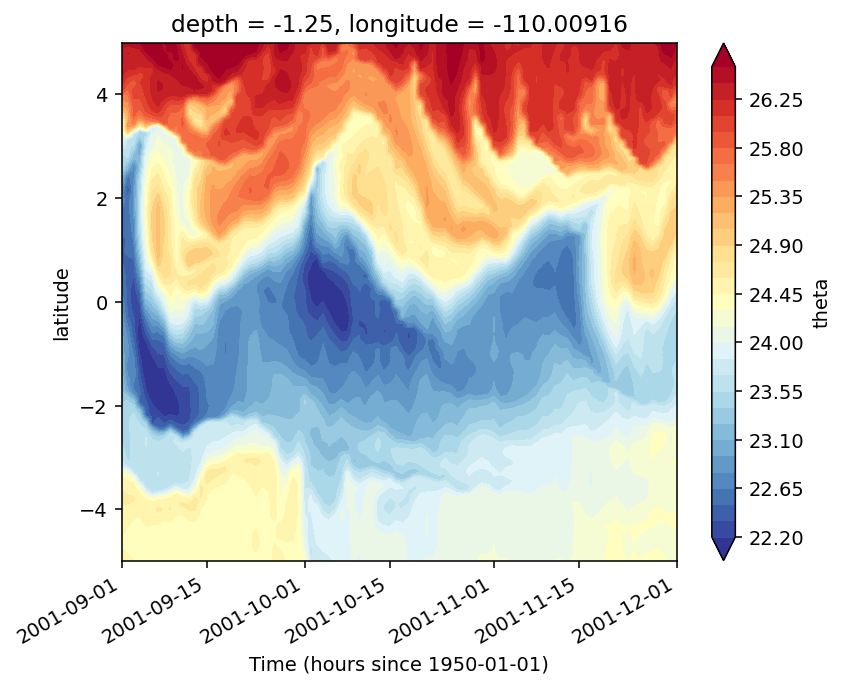

In [ ]:
sections.theta.sel(latitude=slice(-5, 5), time=slice("2001-09-01", "2001-12-01")).sel(longitude=-110, method="nearest", depth=0).plot.contourf(
    levels=30,
    x="time", robust=True, cmap=mpl.cm.RdYlBu_r
)

In [ ]:
np.logspace(-6, -1, 24)

array([1.00000000e-06, 1.64964807e-06, 2.72133877e-06, 4.48925126e-06,
       7.40568469e-06, 1.22167735e-05, 2.01533769e-05, 3.32459793e-05,
       5.48441658e-05, 9.04735724e-05, 1.49249555e-04, 2.46209240e-04,
       4.06158599e-04, 6.70018750e-04, 1.10529514e-03, 1.82334800e-03,
       3.00788252e-03, 4.96194760e-03, 8.18546731e-03, 1.35031404e-02,
       2.22754295e-02, 3.67466194e-02, 6.06189899e-02, 1.00000000e-01])

In [ ]:
cluster.scale(0)

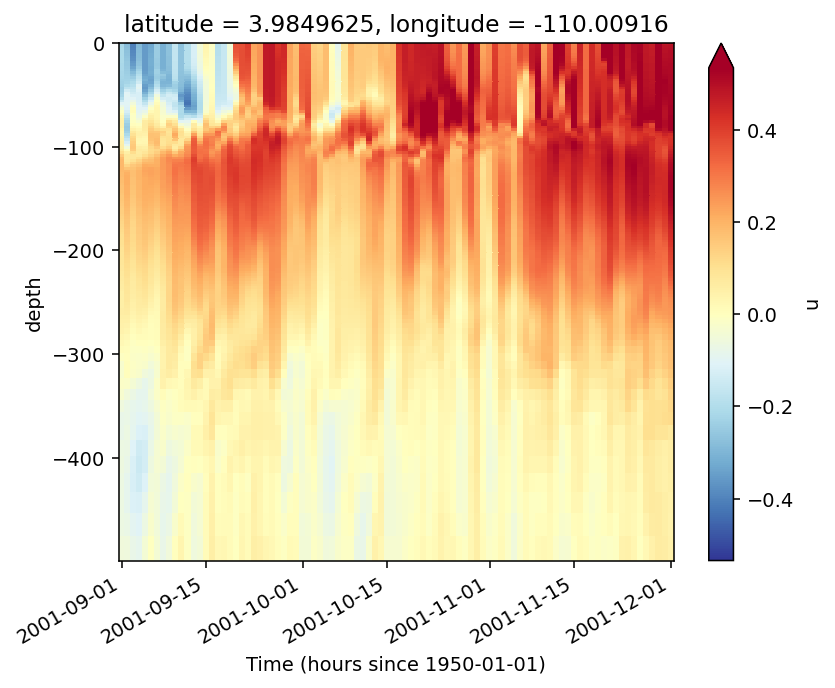

In [ ]:
sections.u.sel(time=slice("2001-09-01", "2001-12-01")).sel(latitude=4, longitude=-110, method="nearest").plot(
    x="time", robust=True, cmap=mpl.cm.RdYlBu_r,)

In [ ]:
sections = xr.open_zarr("/glade/work/dcherian/pump/gcm_20_sections.zarr", consolidated=True)

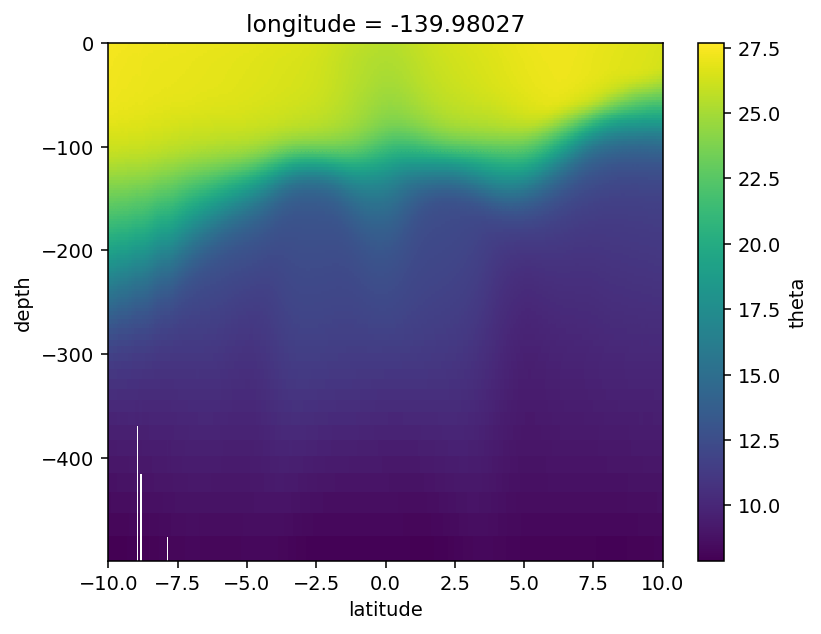

In [ ]:
sections.groupby("time.year").mean().theta.mean("year").isel(longitude=1).plot(y="depth")

In [ ]:
cluster.scale(12)

In [ ]:
client.restart()

distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-a6588a0a165051efebe29bb33b16f37f', 0, 0, 0, 0)": [], "('getitem-6ac305308f7a79efbd118afd0cc900df', 0, 0, 0, 0)": [], "('getitem-3fc9738ad38f07e69a0516b275845b9e', 0, 0, 0, 0)": [], "('getitem-3ed954b682e9dcee64a687e9137b6f8d', 0, 0, 0, 0)": [], "('getitem-e5fb92f6857be8165b3ae8b7b5525e3e', 0, 0, 0, 0)": []} state: [None, None, None, None, None] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-a6588a0a165051efebe29bb33b16f37f', 0, 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-6ac305308f7a79efbd118afd0cc900df', 0, 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-3fc9738ad38f07e69a0516b275845b9e', 0, 0, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-3ed954b682e9dcee64a687e9137b6f8d', 0, 0, 0, 0)
NoneType: No

<Client: 'tcp://128.117.181.223:43680' processes=0 threads=0, memory=0 B>

# read sections

In [ ]:
gcm20 =  xr.open_zarr("/glade/work/dcherian/pump/gcm_20_sections.zarr", consolidated=True).chunk({"time": 1000, "depth": 10})
gcm1 = xr.open_zarr("/glade/work/dcherian/pump/gcm1-sections-retry.zarr/", consolidated=True).chunk({"time": 1000, "depth": 10})

In [ ]:
time = xr.open_mfdataset("/glade/campaign/cgd/oce/people/bachman/TPOS_MITgcm_1_hb/HOLD_NC_LINKS/obs_subset/tao*.nc").time
gcm1["time"] = time
del gcm1["Jq"]

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation 

In [ ]:
tao = pump.obs.read_tao_zarr("gridded")

In [ ]:
xfilter.bandpass(gcm1.theta.chunk({"time": -1}), coord="time", freq=[1/10, 1/50], cycles_per="D")

<xarray.DataArray 'theta' (depth: 345, latitude: 480, longitude: 4, time: 2947)>
dask.array<where, shape=(345, 480, 4, 2947), dtype=float32, chunksize=(10, 138, 1, 2947), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1995-09-01 ... 1997-01-04T12:00:00
  * depth      (depth) float32 -0.5 -1.5 -2.5 ... -5565.922 -5665.922 -5765.922
  * latitude   (latitude) float32 -12.0 -11.949896 -11.899791 ... 11.949896 12.0
  * longitude  (longitude) int64 -110 -125 -140 -155

In [ ]:
import pandas as pd
roms = xr.open_mfdataset("/glade/scratch/dwhitt/TPOS/tpos20/OUT/ocean_sta_tpos20_1.nc", combine="by_coords", parallel=True)
roms = roms.sel(station = ((np.abs(roms.lat_rho) < 12) & (np.abs(roms.lon_rho) < 1000)))
lat = np.round(roms.lat_rho.values, 2)
lon = np.round(roms.lon_rho.values, 2)
roms = roms.assign_coords(
    station = pd.MultiIndex.from_arrays([lat, lon], names=["latitude", "longitude"])
)
roms = roms.unstack("station")

Cs = roms.Cs_r
s = roms.s_rho
hc = roms.hc
S = hc * s + (roms.h - hc) * Cs
z = S # + roms.zeta * (1 + S/roms.h)

roms = roms.assign_coords(s_rho=z[:,0,0].values).rename({"s_rho": "depth", "ocean_time": "time"})
roms = roms.drop_vars(["lon_rho", "lat_rho"])
roms = roms.sortby("depth", ascending=False)
roms["time"] = pd.date_range("1984-09-02", freq="H", periods=4321)
roms

<xarray.Dataset>
Dimensions:        (boundary: 4, depth: 50, latitude: 21, longitude: 9, s_w: 51, time: 4321, tracer: 2)
Coordinates:
  * depth          (depth) float64 -3.492 -10.5 -17.6 ... -3.574e+03 -3.944e+03
  * s_w            (s_w) float64 -1.0 -0.98 -0.96 -0.94 ... -0.04 -0.02 0.0
  * time           (time) object 0027-09-02 00:00:00 ... 0028-03-01 00:00:00
  * latitude       (latitude) float64 -8.0 -7.0 -6.0 -5.0 ... 5.0 6.0 7.0 8.0
  * longitude      (longitude) float64 -162.5 -155.0 -147.5 ... -110.0 -102.5
Dimensions without coordinates: boundary, tracer
Data variables:
    ntimes         int32 129601
    ndtfast        int32 20
    dt             float64 120.0
    dtfast         float64 6.0
    dstart         object 0027-09-02 00:00:00
    nHIS           int32 3600
    ndefHIS        int32 0
    nRST           int32 3600
    ntsAVG         int32 1
    nAVG           int32 720
    ndefAVG        int32 0
    nSTA           int32 30
    Falpha         float64 2.0
    Fbeta          float64 4.0
    Fgamma         float64 0.284
    nl_tnu4        (tracer) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    nl_visc4       float64 1.24e+09
    LuvSponge      int32 0
    LtracerSponge  (tracer) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    Akt_bak        (tracer) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    Akv_bak        float64 1e-05
    rdrg           float64 0.000265
    rdrg2          float64 0.003
    Zob            float64 0.02
    Zos            float64 0.02
    Znudg          float64 0.0
    M2nudg         float64 0.0
    M3nudg         float64 1.0
    Tnudg          (tracer) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    FSobc_in       (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    FSobc_out      (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    M2obc_in       (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    M2obc_out      (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    Tobc_in        (boundary, tracer) float64 dask.array<chunksize=(4, 2), meta=np.ndarray>
    Tobc_out       (boundary, tracer) float64 dask.array<chunksize=(4, 2), meta=np.ndarray>
    M3obc_in       (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    M3obc_out      (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    rho0           float64 1.025e+03
    gamma2         float64 1.0
    LuvSrc         int32 0
    LwSrc          int32 0
    LtracerSrc     (tracer) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    LsshCLM        int32 0
    Lm2CLM         int32 0
    Lm3CLM         int32 0
    LtracerCLM     (tracer) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    LnudgeM2CLM    int32 0
    LnudgeM3CLM    int32 0
    LnudgeTCLM     (tracer) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    spherical      int32 1
    xl             float64 8.163e+06
    el             float64 2.674e+06
    Vtransform     int32 1
    Vstretching    int32 1
    theta_s        float64 5.0
    theta_b        float64 0.0
    Tcline         float64 75.0
    hc             float64 75.0
    grid           int32 1
    Cs_r           (depth) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    Cs_w           (s_w) float64 dask.array<chunksize=(51,), meta=np.ndarray>
    Ipos           (latitude, longitude) float64 dask.array<chunksize=(21, 9), meta=np.ndarray>
    Jpos           (latitude, longitude) float64 dask.array<chunksize=(21, 9), meta=np.ndarray>
    h              (latitude, longitude) float64 dask.array<chunksize=(21, 9), meta=np.ndarray>
    angle          (latitude, longitude) float64 dask.array<chunksize=(21, 9), meta=np.ndarray>
    zeta           (time, latitude, longitude) float32 dask.array<chunksize=(4321, 21, 9), meta=np.ndarray>
    u              (time, depth, latitude, longitude) float32 dask.array<chunksize=(4321, 50, 21, 9), meta=np.ndarray>
    v              (time, depth, latitude, longitude) float32 das

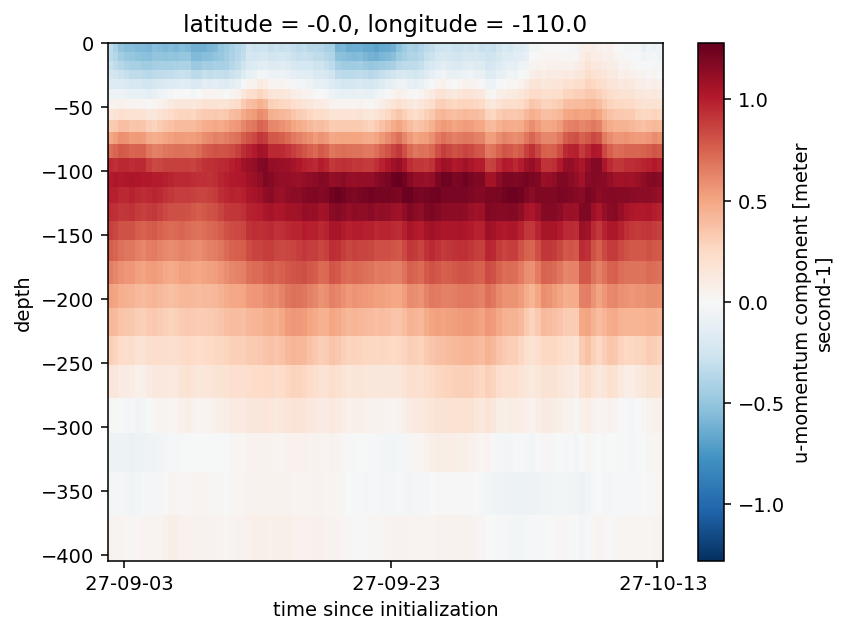

In [ ]:
(
    roms
    .sel(latitude=0, longitude=-110, depth=slice(-400))
    .u
    .isel(time=slice(0, 1000, 10))
    .plot(y="depth")
)

In [ ]:
uft = xrft.dft(
    roms.u.sel(latitude=0, longitude=-140, depth=slice(-400)),
    dim=["time"],
    detrend=True,
    window=True,
).isel(freq_time=slice(roms.sizes["time"]//2, None)) * 2
uft.load()

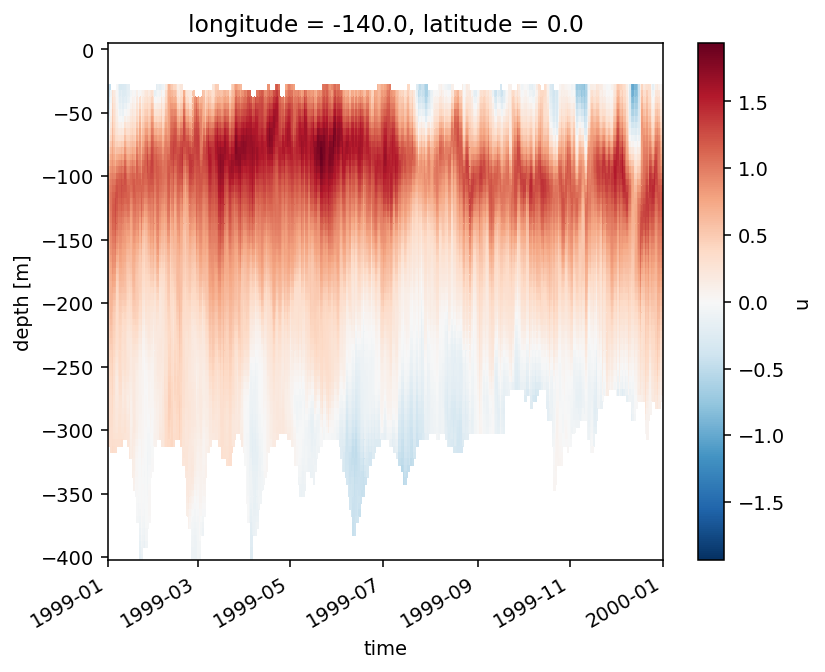

In [ ]:
u140 = (
    adcp.u
    .sel(longitude=-140, depth=slice(-400), time="1999")
    .interpolate_na("time", max_gap="3D")
)
u140.plot(x="time")

In [ ]:
taouft = xrft.dft(
    u140.sel(depth=slice(-50, -150)),
    dim=["time"],
    detrend=True,
    window=True,
).isel(freq_time=slice(u140.sizes["time"]//2, None)) * 2

# Compare models

## Spectra at (0, 140)

In [ ]:
tao.attrs["name"] = "TAO 2000-01"
gcm1.attrs["name"] = "gcm 1m 1995-96"
gcm20.attrs["name"] = "gcm 20yr 2000-01"
roms.attrs["name"] = "ROMS 1984-85"

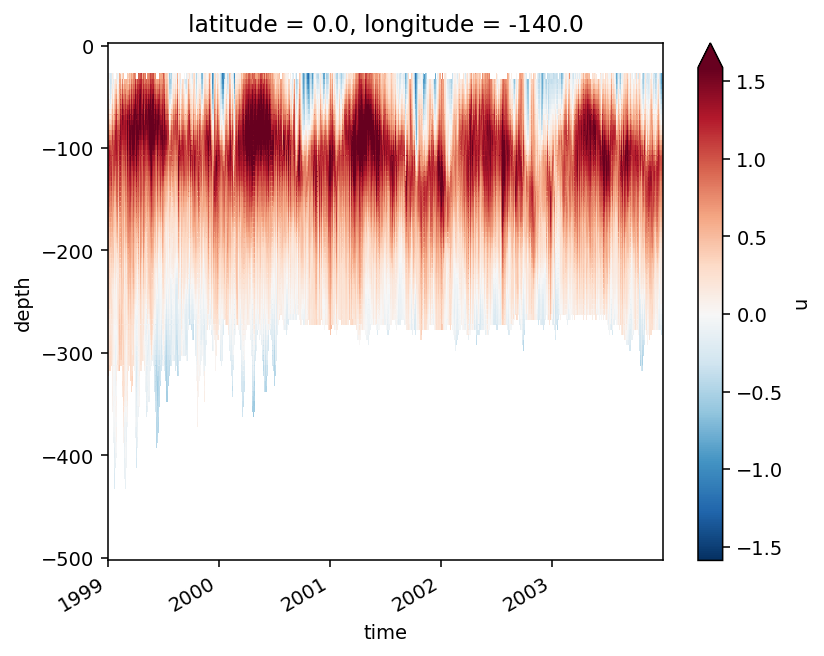

In [ ]:
tao.u.sel(longitude=-140, time=slice("1999", "2003")).plot(x="time", robust=True)

TAO 2000-01 -65.0
=== depths = -25.0
=== depths = -25.0
=== depths = -25.0
ROMS 1984-85 -106.56441735867062
=== depths = -66.56441735867062
=== depths = -66.56441735867062
=== depths = -66.56441735867062
gcm 1m 1995-96 -85.5
=== depths = -45.5
=== depths = -45.5
=== depths = -45.5
gcm 20yr 2000-01 -81.25
=== depths = -41.25
=== depths = -41.25
=== depths = -41.25
TAO 2000-01 -65.0
=== depths = -45.0
=== depths = -45.0
=== depths = -45.0
ROMS 1984-85 -106.56441735867062
=== depths = -86.56441735867062
=== depths = -86.56441735867062
=== depths = -86.56441735867062
gcm 1m 1995-96 -85.5
=== depths = -65.5
=== depths = -65.5
=== depths = -65.5
gcm 20yr 2000-01 -81.25
=== depths = -61.25
=== depths = -61.25
=== depths = -61.25


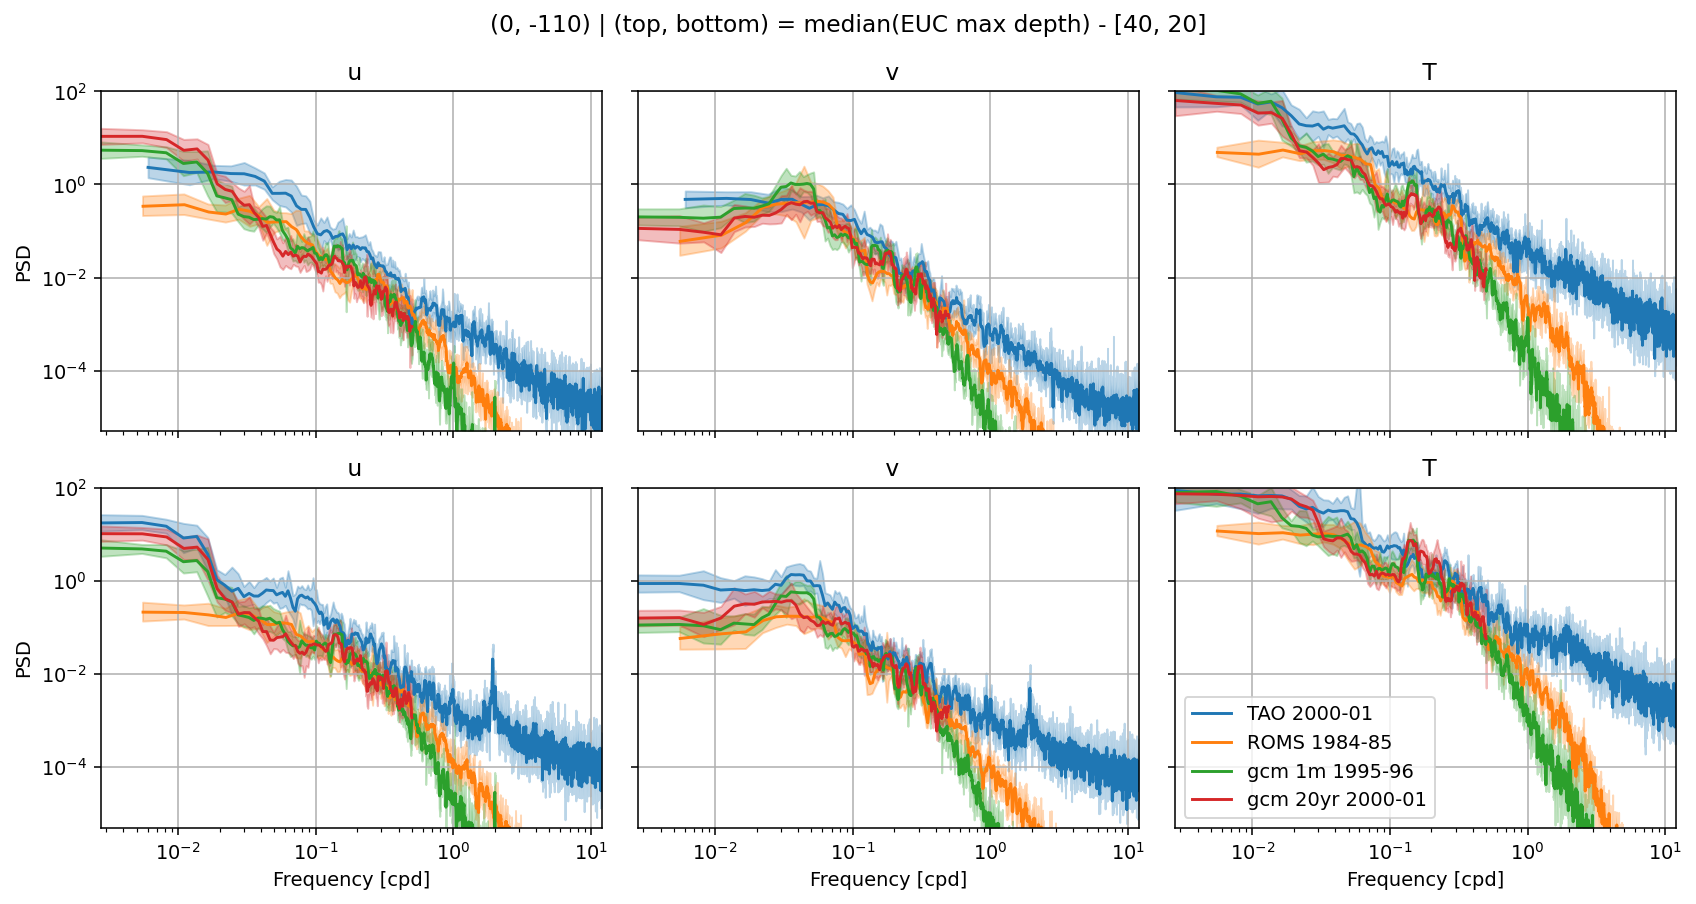

In [ ]:
def slice_depth(ds, z):
    return ds.sel(depth=z, method="nearest")

f, axx = plt.subplots(2, 3, sharex=True, sharey=True, constrained_layout=True)
f.set_size_inches((12, 6))


latitude = 0
longitude = -110
depths = [40, 20]

ax = dict()
for z, axes in zip(depths, axx):
    ax[z] = dict(zip("uvT", axes))

for depth in depths:
    for ds in [
        tao.sel(time=slice("2000-09-01", "2001-09-01")), 
        roms.sel(time=slice("1984-09-01", "1985-09-01")).rename({"temp": "T"}), 
        gcm1.sel(time=slice("1995-09-01", "1996-09-01")).rename({"theta": "T"}), 
        gcm20.sel(time=slice("2000-09-01", "2001-09-01")).rename({"theta": "T"}),
    ]:
        for varname, axis in ax[depth].items():
            var = ds[varname]
            if "latitude" in var.dims:
                var = var.sel(latitude=slice(latitude-0.25, latitude+0.25)).mean("latitude")
                
            var = (
                var.sel(longitude=longitude, method="nearest")
                .sel(depth=slice(-250))
                .reset_coords(drop=True)
                .compute()
            )
            if varname == "u":
                eucmax = pump.calc.get_euc_max(var.dropna("depth", how="all")).median("time").values
                print(ds.name,eucmax)

            print(f"=== depths = {eucmax + depth}")
            var = var.pipe(slice_depth, eucmax + depth)
            
            dcpy.ts.PlotSpectrum(
                var, 
                ax=axis, 
                label=ds.attrs["name"],
            )
            axis.grid(True)
            axis.set_ylim(5e-6, 1e2)
        
[aa.set_ylabel("") for aa in axx[:, 1:].flat]
[aa.set_xlabel("") for aa in axx[:-1, :].flat]
f.suptitle(f"({latitude}, {longitude}) | (top, bottom) = median(EUC max depth) - {depths}", y=1.05)
axx.flat[-1].legend(loc="lower left")
f.savefig(f"../images/validation_spectra_all_0_{np.abs(longitude)}.png")

## TIW variance at (0, -140)

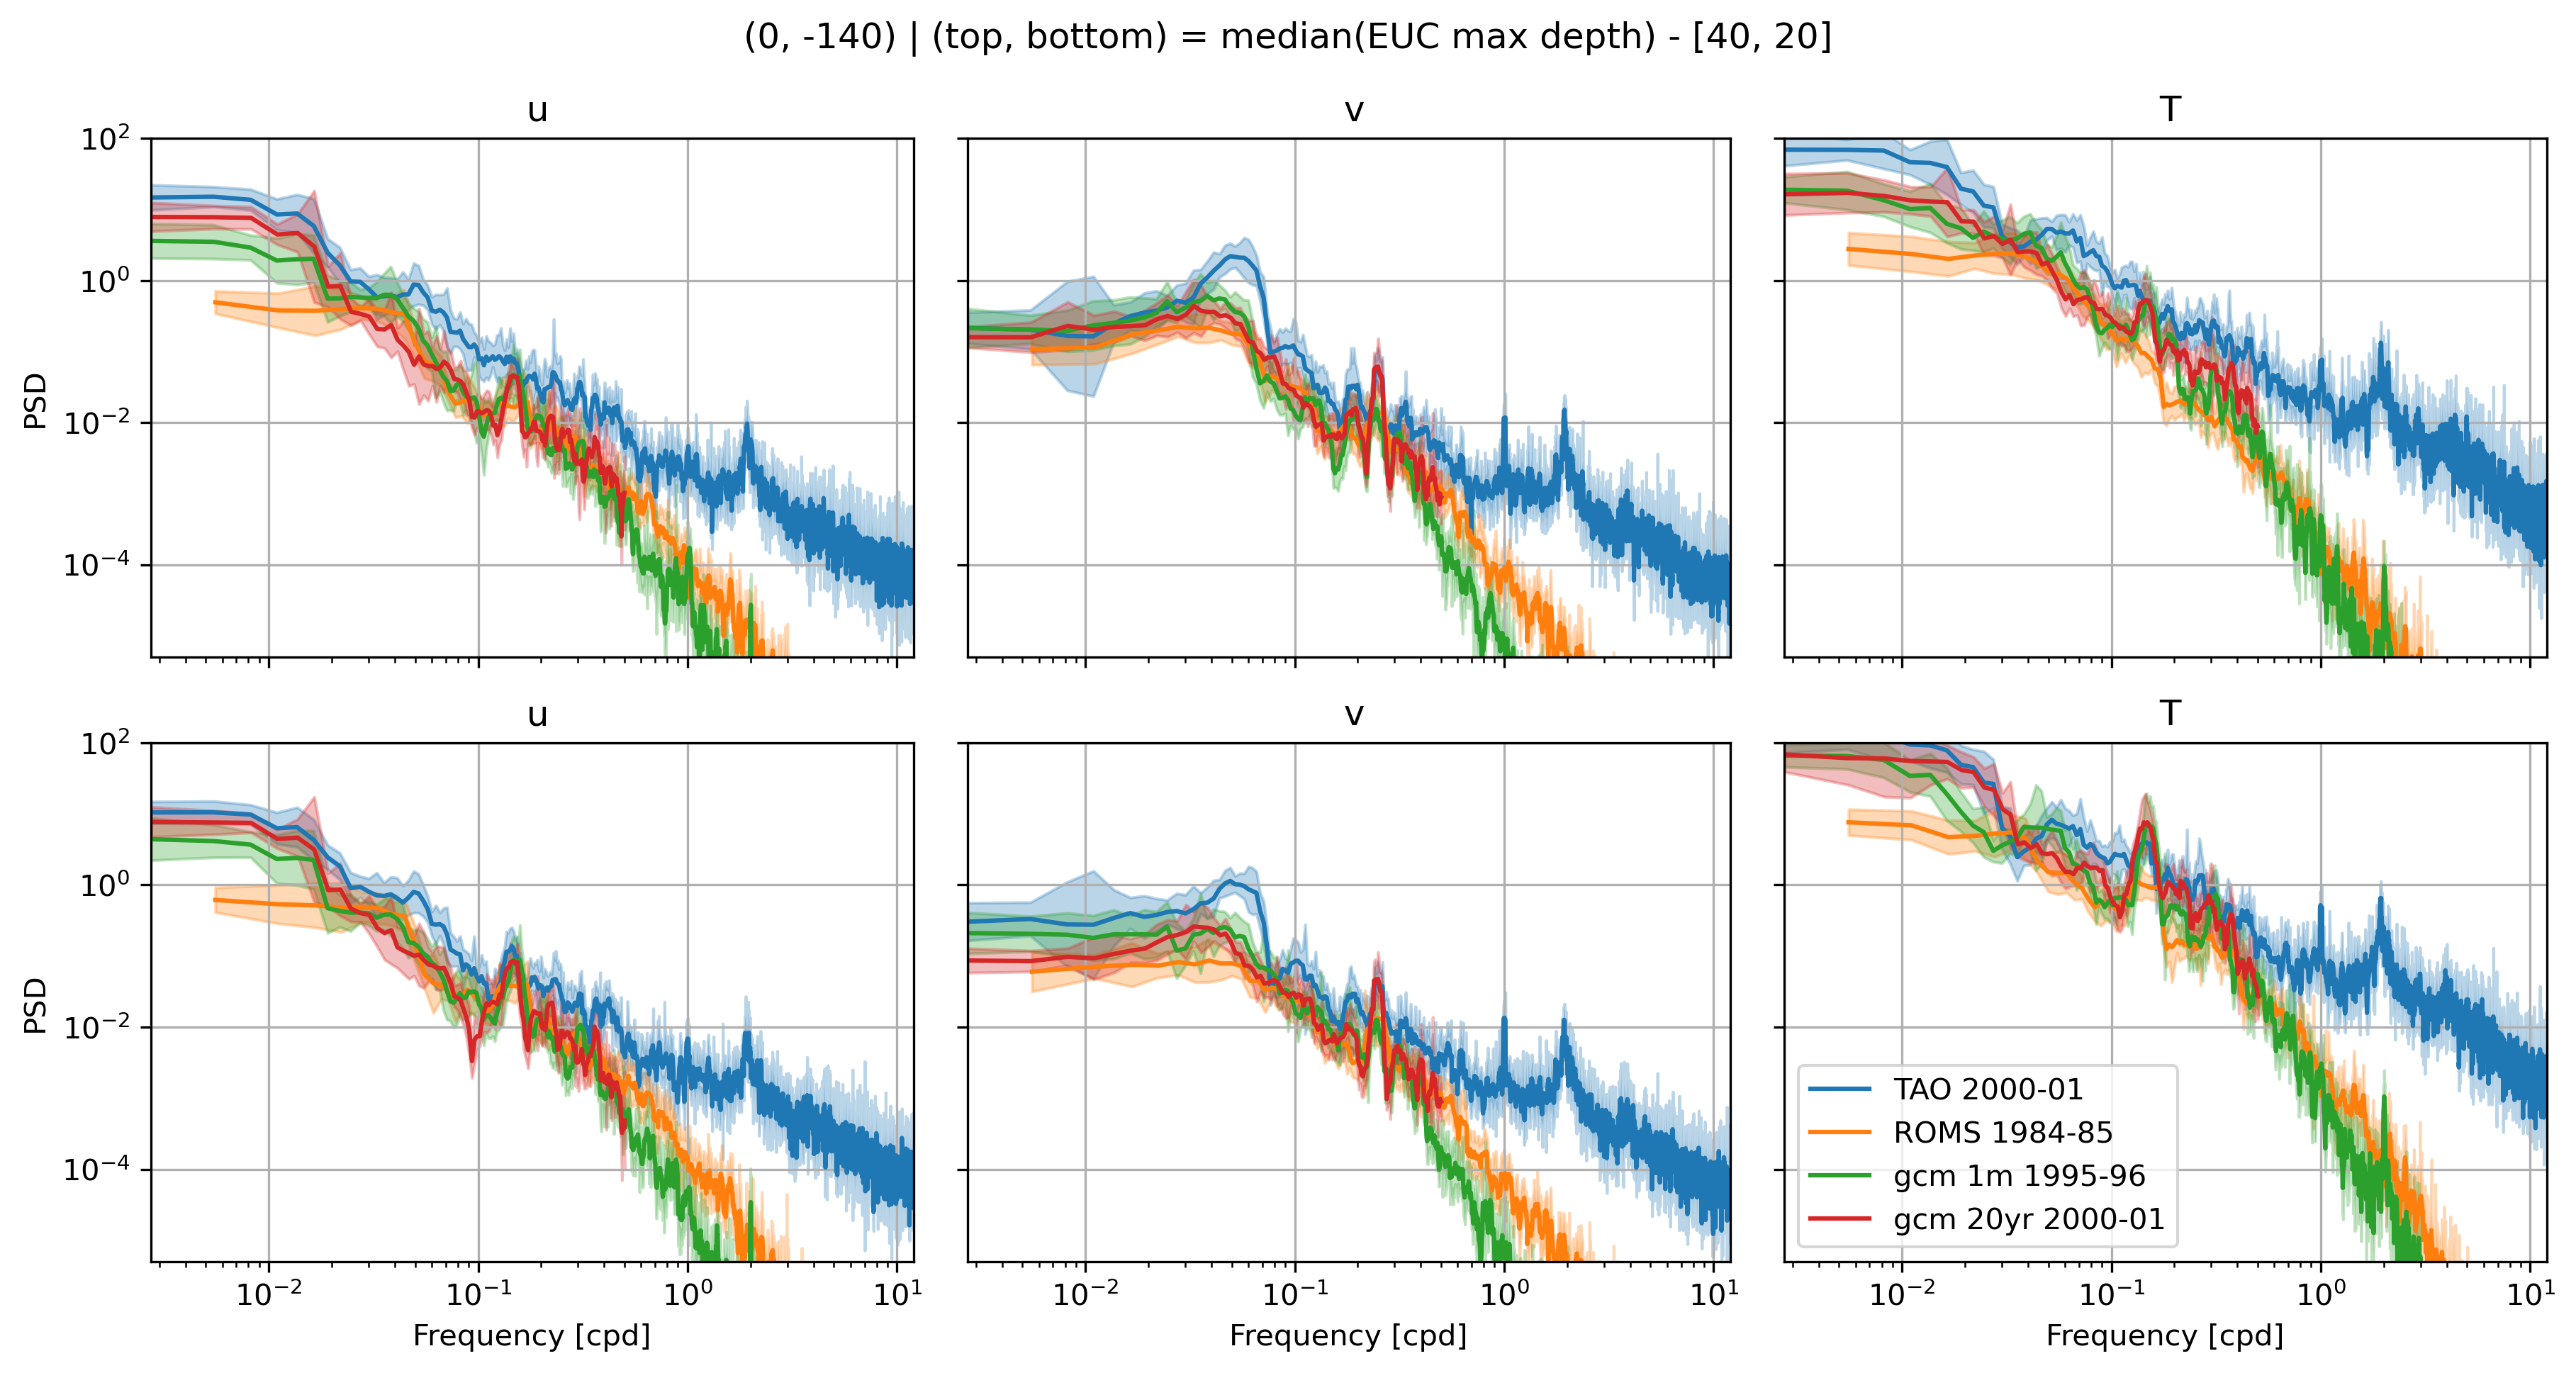

In [ ]:
Image("../images/validation_spectra_all_0_140.png")

### TIW variance at (0, -110)

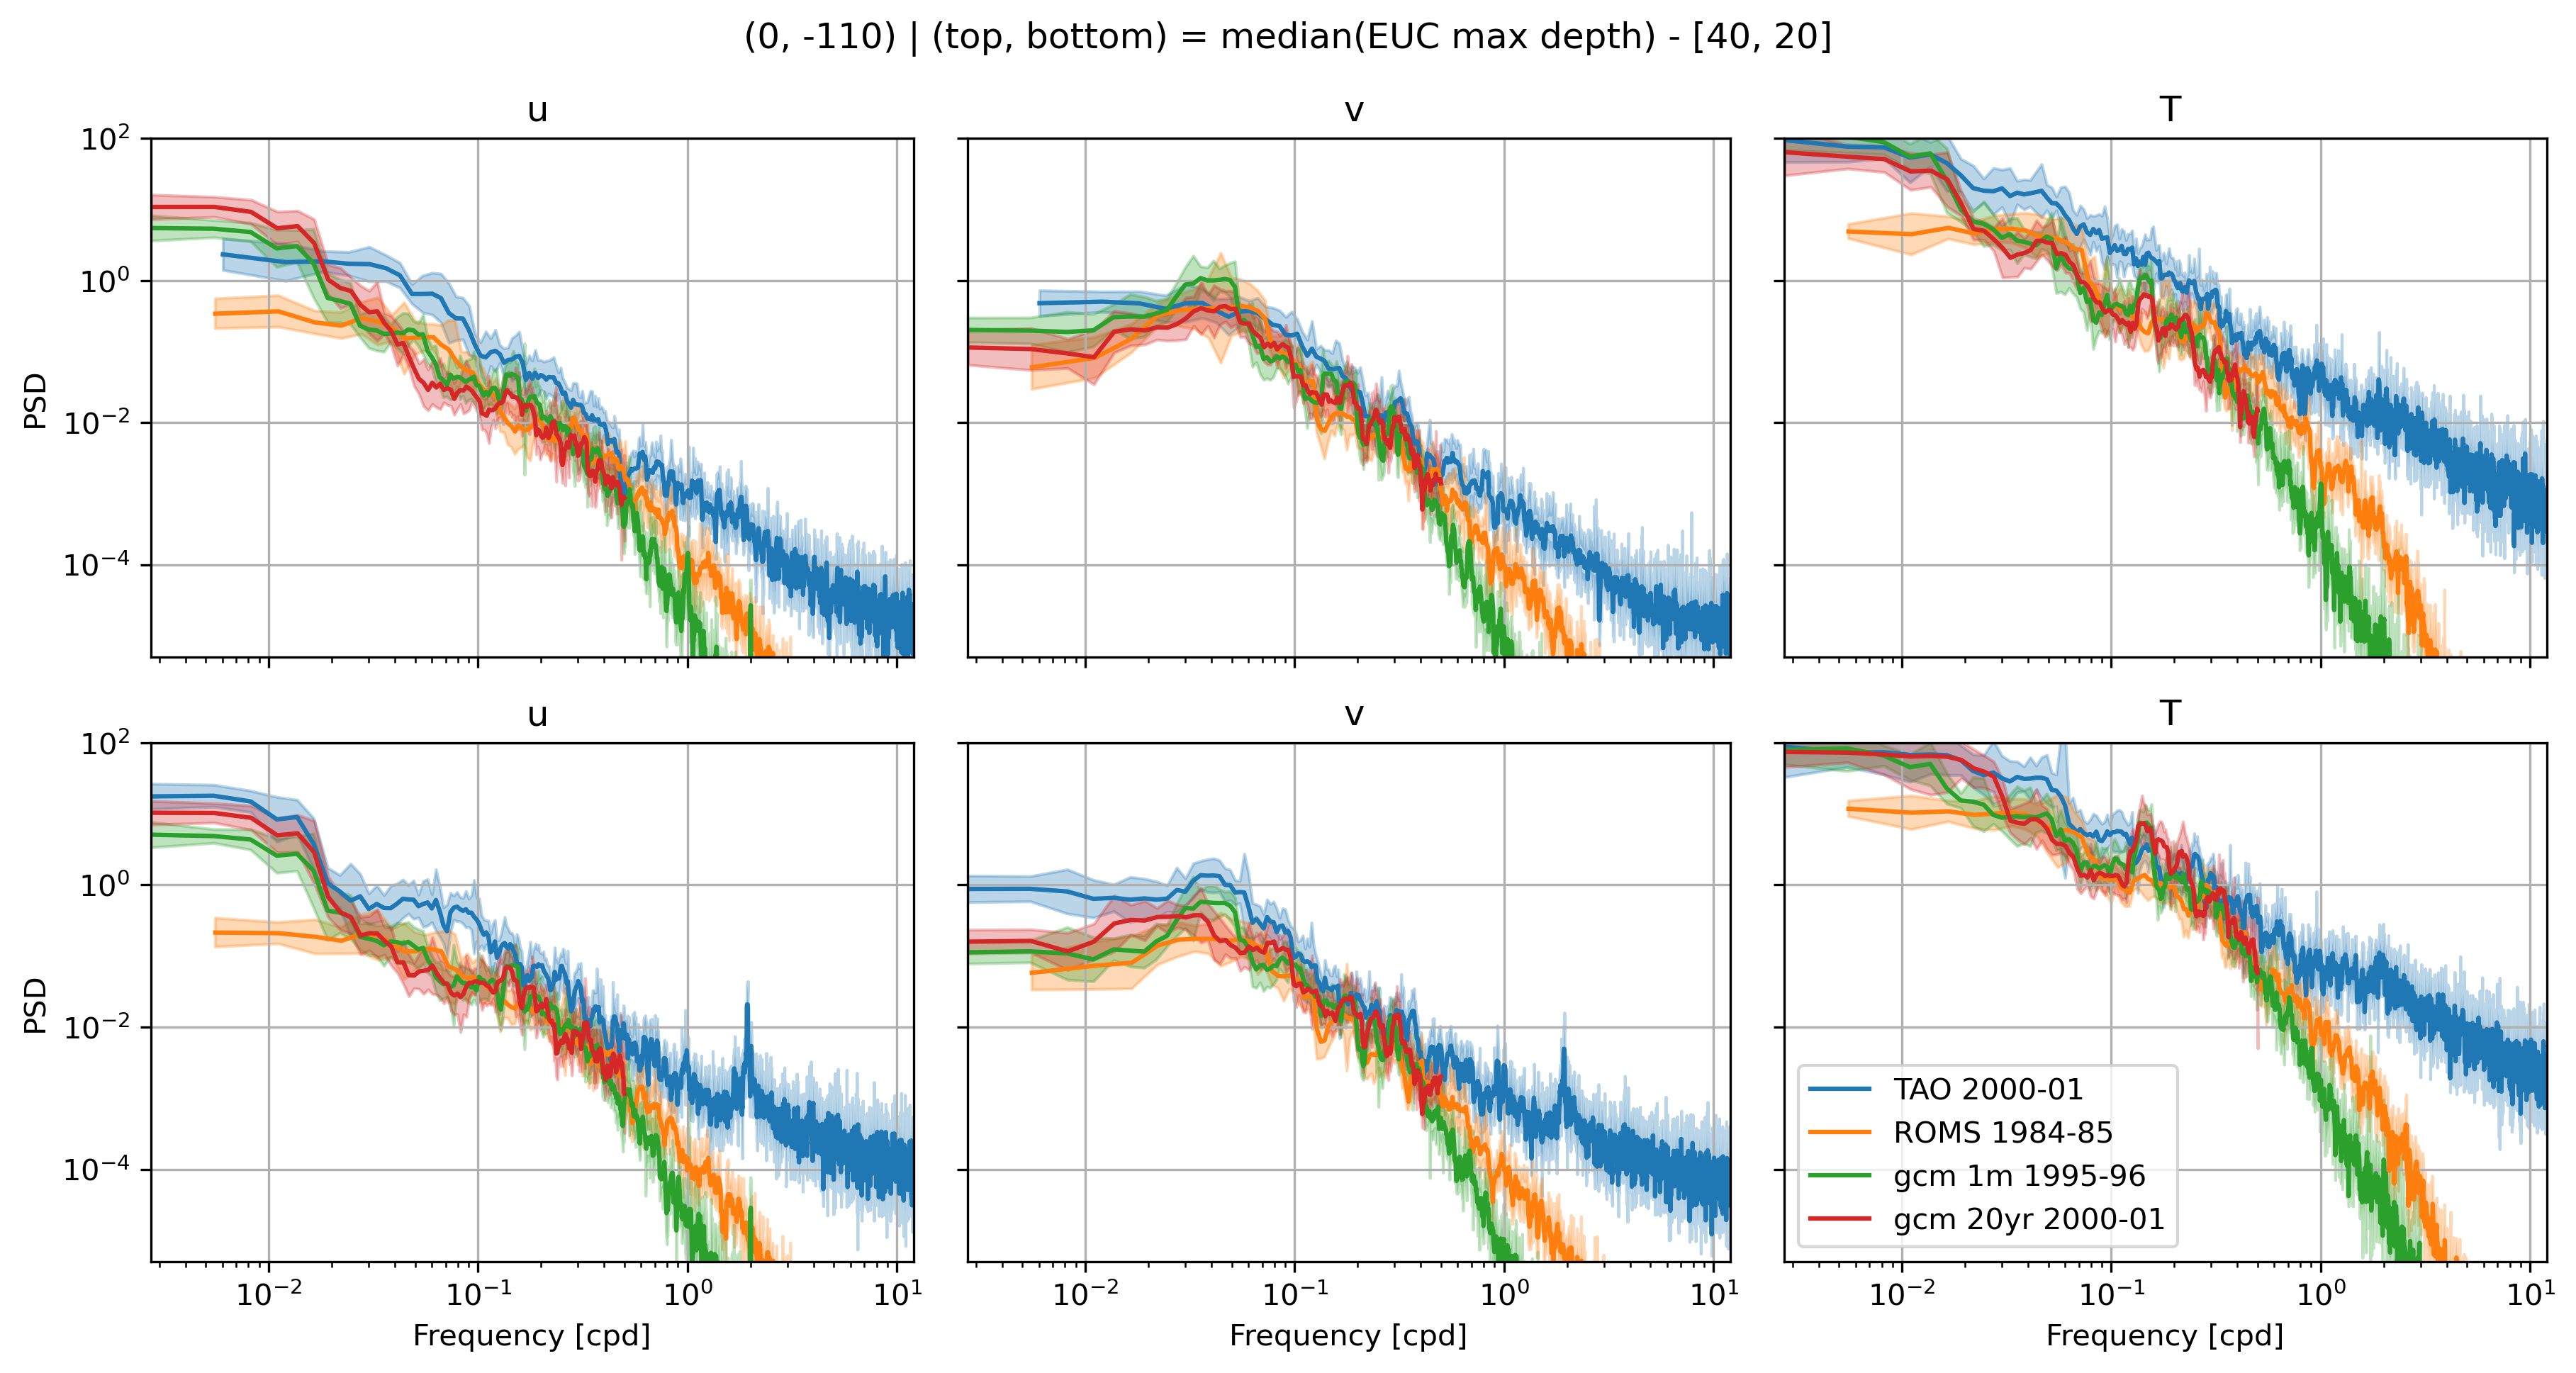

In [ ]:
Image("../images/validation_spectra_all_0_110.png")

### previous attempts

([<matplotlib.lines.Line2D at 0x2b69cf540630>],
 <matplotlib.axes._subplots.AxesSubplot at 0x2b69ca595160>)

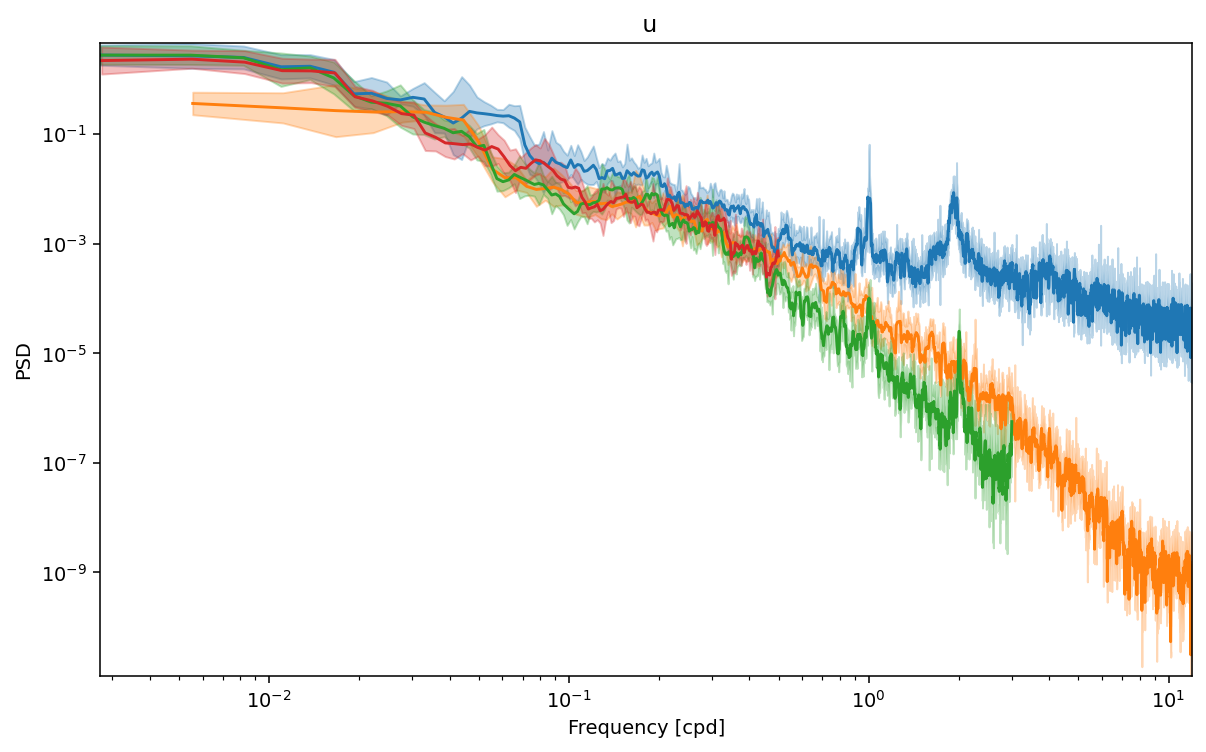

In [ ]:
dcpy.ts.PlotSpectrum(
    tao.u.sel(longitude=-140, time="1999").sel(depth=slice(-50, -150)).mean("depth")
)
dcpy.ts.PlotSpectrum(
    roms.u.sel(latitude=0, longitude=-140, depth=slice(-50, -150)).mean("depth"),
    ax=plt.gca()
)
dcpy.ts.PlotSpectrum(
    gcm1.u
    .sel(latitude=0, longitude=-140, time="1996", method="nearest")
    .sel(depth=slice(-50, -150))
    .mean("depth"),
    ax=plt.gca()
)
dcpy.ts.PlotSpectrum(
    gcm20.u.sel(latitude=0, longitude=-140, time="1999", method="nearest")
    .sel(depth=slice(-50, -150)).mean("depth"),
    ax=plt.gca()
)

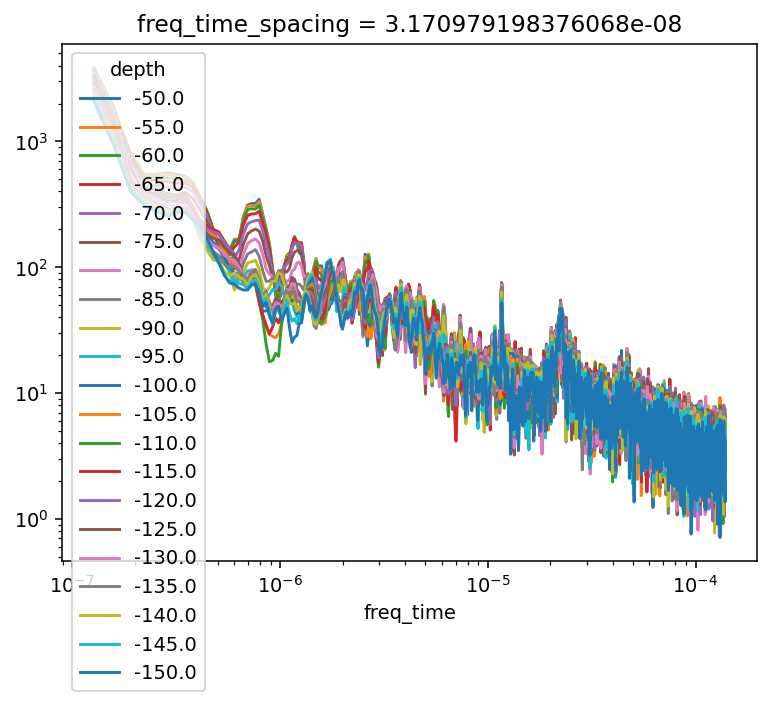

In [ ]:
(
    np.abs(taouft)
    .sel(depth=slice(-50, -150))
    .rolling(freq_time=5).mean()
    .plot.line(yscale="log", hue="depth", xscale="log")
);

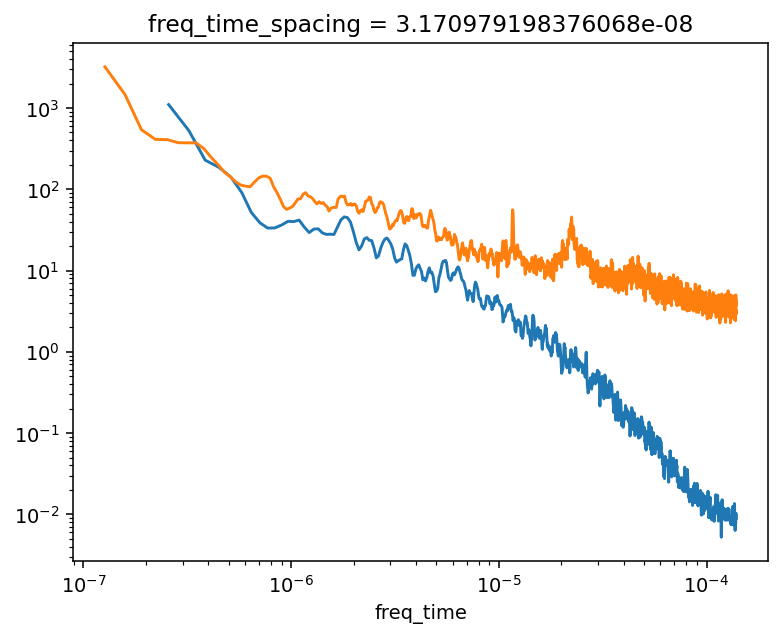

In [ ]:
np.abs(uft).sel(depth=slice(-50, -150)).mean("depth").rolling(freq_time=5).mean().plot.line(yscale="log", hue="depth")
np.abs(taouft).sel(depth=slice(-50, -150)).mean("depth").rolling(freq_time=5).mean().plot.line(yscale="log", hue="depth", xscale="log")

# previous round validation

just checks model T against tao

In [ ]:
johnson = pump.obs.read_johnson()

In [ ]:
meanT = gcm1.tao.theta.groupby("time.year").mean("time").compute()

In [ ]:
taoT = tao.temp.sel(latitude=[0, 2, 5], longitude=-140, time=slice("1990", "2000")).mean("time").compute()

In [ ]:
modelT = meanT.sel(longitude=-140, year=1996, latitude=[0, 2, 5])

# .plot(col="latitude")
# taoT.dropna("depth").plot(hue="latitude", ls="--")

In [ ]:
merged = xr.Dataset()
merged["gcm"] = modelT
merged["tao"] = taoT.dropna("depth").interp(depth=merged.depth)
merged["johnson"] = johnson.temp.sel(latitude=[0, 2, 5], longitude=-140).interp(depth=merged.depth)
merged

<xarray.Dataset>
Dimensions:    (depth: 284, latitude: 3)
Coordinates:
  * latitude   (latitude) float64 0.0 2.0 5.0
    longitude  float64 -140.0
  * depth      (depth) float32 -0.5 -1.5 -2.5 ... -439.69885 -458.8152 -479.7476
    year       int64 1996
Data variables:
    gcm        (depth, latitude) float32 25.202759 25.87142 ... 7.8435197
    tao        (latitude, depth) float64 nan 25.97 25.9 ... 8.728 8.567 8.39
    johnson    (depth, latitude) float64 nan nan nan nan ... 8.242 8.255 8.391

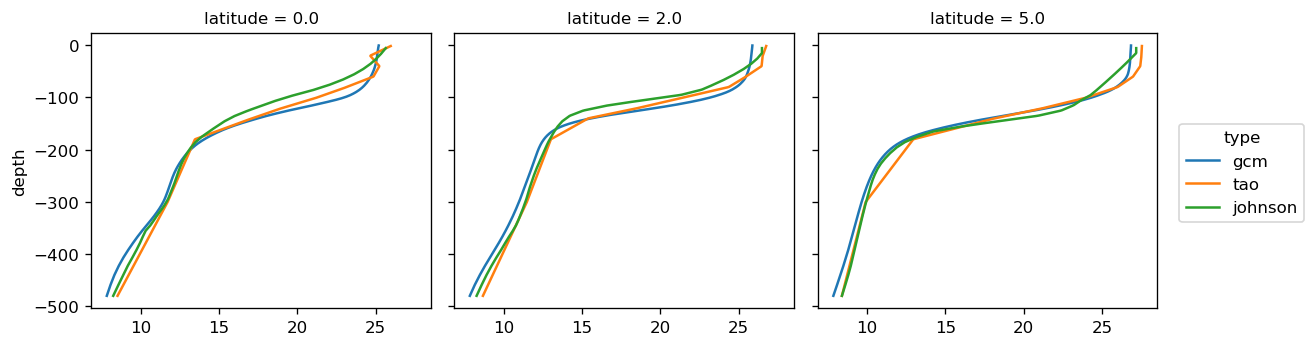

In [ ]:
merged.to_array("type").plot.line(col="latitude", hue="type", y="depth")

In [ ]:
tao = pump.obs.read_tao()

/glade/u/home/dcherian/pump/pump/obs.py:190: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  chunks={"lat": 1, "lon": 1, "depth": 5},
/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation w